# Schelling's model of segregation

Described [here](https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation).

Implementation method [here](http://nifty.stanford.edu/2014/mccown-schelling-model-segregation/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

INITIAL VALUES FOR VARIABLES

In [2]:
N  = 20

density = 0.8  #starting percentage
f1      = 0.4  #fraction of '1' in starting population
f_1     = 1-f1 #fraction of '-1' in starting population

t  =  0.5     #percentage of neighbourhood that must be like the agent

# define color map 
color_map = {-1: np.array([255, 0, 0]), # red
             0: np.array([255, 255, 255]), # green
             1: np.array([0, 0, 255])} # blue 

In [3]:
#initialize matrix
matrix = list()

for i in range(N):
    linha = list()
    for j in range(N):
        agent = list()
        for k in range(2):
            agent.append(0)
        linha.append(agent)
    matrix.append(linha)       

In [4]:
#fill matrix
for linha in range(len(matrix)):
    for coluna in range(len(matrix[linha])):
        if (rd.random() <= density):
            if (rd.random() <= f1):
                matrix[linha][coluna] = 1
            else:
                matrix[linha][coluna] = -1

In [19]:
def make_matrix(N):
    matrix = list()

    # make blank matrix (each entry is a list with two values: type (ethnicity) and wealth/income 
    for i in range(N):
        linha = list()
        for j in range(N):
            agent = list()
            for k in range(2):
                agent.append(0)
            linha.append(agent)
        matrix.append(linha)
        
    # fill agent type (ethnicity)
    for linha in range(N):
        for coluna in range(N):
            if (rd.random() <= density):
                if (rd.random() <= f1):
                    matrix[linha][coluna][0] = 1
                else:
                    matrix[linha][coluna][0] = -1
                    
    # fill agent wealth/income
    for linha in range(N):
        for coluna in range(N):
            if (matrix[linha][coluna][0] == 1):
                matrix[linha][coluna][1] = 0 # get random number from type 1 wealth/income distribution function
                
            if (matrix[linha][coluna][0] == -1):
                matrix[linha][coluna][1] = 0 # get random number from type -1 wealth/income distribution function
    
    return matrix

Code to manipulate color from [here](https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color).

In [6]:
def print_matrix(matrix, marker=False, save=False, filename=None):
    N = len(matrix)
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(1, 1, 1)
    # make a 3d numpy array that has a color channel dimension   
    data_3d = np.ndarray(shape=(N, N, 3), dtype=int)
    for i in range(0, N):
        for j in range(0, N):
            data_3d[i][j] = color_map[matrix[i][j]]
            
    if(marker):
        x = [coord[1] for coord in marker]
        y = [coord[0] for coord in marker]

        ax.scatter(x, y, color='lime', s=300/N)
    
    ax.imshow(data_3d)
    if save:
        fig.savefig(filename)

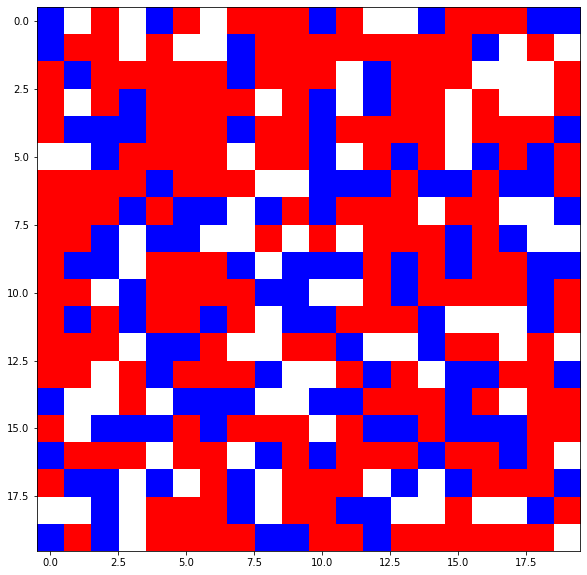

In [7]:
print_matrix(matrix)

In [8]:
def get_neighbours(coordinates, N):
    neighbours = list()
    n_range    = [-1, 0, 1]
    [x, y]     = coordinates
    
    for i in n_range:
        for j in n_range:
            
            neighbour_coords_x = coordinates[0]+i
            neighbour_coords_y = coordinates[1]+j
            
            if (neighbour_coords_x > N - 1):
                neighbour_coords_x = 0
                
            if (neighbour_coords_x < 0):
                neighbour_coords_x = N - 1
            
            if (neighbour_coords_y > N - 1):
                neighbour_coords_y = 0
                
            if (neighbour_coords_y < 0):
                neighbour_coords_y = N - 1
                
            if (not(i == 0 and j == 0)):
                neighbours.append([neighbour_coords_x, neighbour_coords_y])
            
            # getting regular/immediate neighbours
            #if ((x+i >= 0 and x+i < N) and (y+j >= 0 and y+j < N)) and (not (i == 0 and j == 0)):
            #    neighbours.append([coordinates[0]+i, coordinates[1]+j])
                  
    return neighbours

def get_empty_space(matrix):
    empty_coords = list()
    for linha in range(len(matrix)):
        for coluna in range(len(matrix)):
            if matrix[linha][coluna] == 0:
                empty_coords.append([linha, coluna])
    return empty_coords
            
def check_neighbours(coordinates, matrix):
    N = len(matrix)
    neighbours = get_neighbours(coordinates,N)
    content = list()
    
    content = [matrix[pos[0]][pos[1]] for pos in neighbours]
    
    return content

In [9]:
print(get_neighbours([0,0], N))
check_neighbours([0, 0], matrix)

[[19, 19], [19, 0], [19, 1], [0, 19], [0, 1], [1, 19], [1, 0], [1, 1]]


[0, 1, -1, 1, 0, 0, 1, -1]

We now need to find the dissatisfied agents

In [10]:
#algo return 1 if agent gathers conditions that satisfy dissatisfaction and 0 if it doesn't

# algo(coordinates, matrix)
def get_dissatisfied(matrix, algo):
    dissatisfied = list()
    for linha in range(len(matrix)):
        for coluna in range(len(matrix)):
            if algo([linha, coluna], matrix):
                dissatisfied.append([linha, coluna])
    return dissatisfied

Simple algorithm that checks if theres a minimum percentage of t neighbours around

In [11]:
def get_tol(coord, N): # tolerance to be a function of r
    min_tol = 3/8
    max_tol = 6/8
    r = np.sqrt((coord[0] - N/2)*(coord[0] - N/2) + (coord[1] - N/2)*(coord[1] - N/2)) # get_r(coord)
    
    tol = 2*(max_tol - min_tol)*r/N + min_tol # linear increase
    # > the maximum tolerance value (max_tol) is at the edges (one requires more neighbours to be of one's type)
    # > the minimum tolerance value (min_tol) is at the grid center (one wants to live in the center so one is
    #   less picky)
    
    return tol

In [12]:
def dis_algo(coord, matrix):
    agent_val = matrix[coord[0]][coord[1]]
    if (agent_val):
        n_agents  = check_neighbours(coord, matrix)

        n_1 = 0
        n0  = 0
        n1  = 0

        for agent in n_agents:
            if agent == -1:
                n_1 += 1
            if agent == 0:
                n0  += 1
            if agent == 1:
                n1  += 1

        if (n_1 + n1) == 0:
            return 0

        val_sum = {-1:n_1, 0:n0, 1:n1}
        
        if val_sum[agent_val]/(n_1 + n1) < get_tol(coord,len(matrix)):
            return 1
        return 0

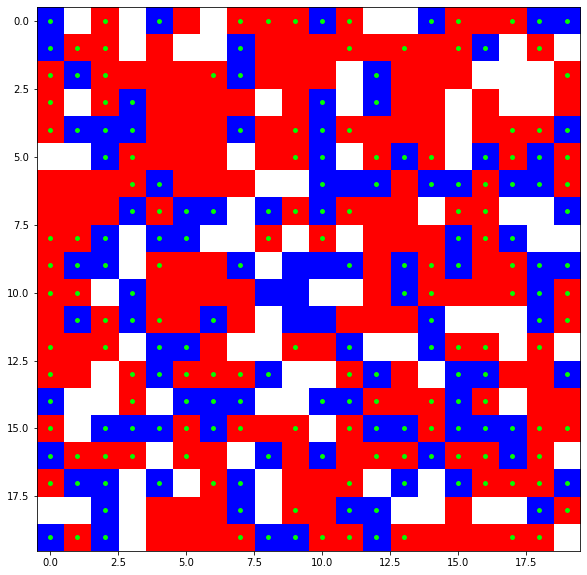

In [13]:
print_matrix(matrix, get_dissatisfied(matrix, dis_algo))

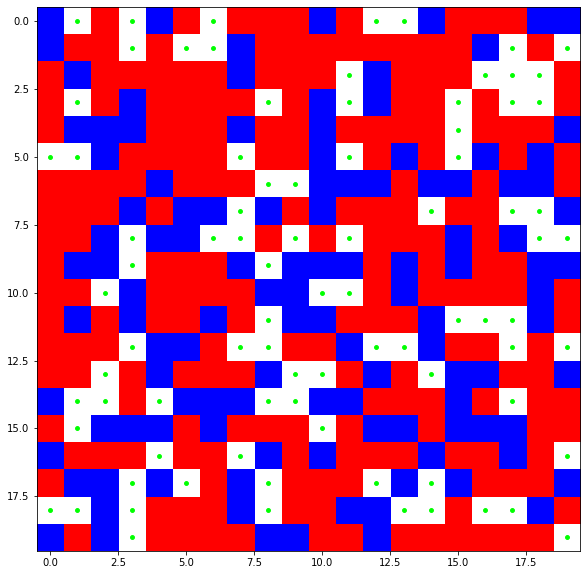

In [14]:
print_matrix(matrix, get_empty_space(matrix))

In [15]:
def iteration(matrix):
    new_matrix = matrix.copy()
    
    empty_space  = get_empty_space(matrix)
    dissatisfied = get_dissatisfied(matrix, dis_algo)
    
    if dissatisfied == []:
        return "STOP"
    
    for agent in dissatisfied:
        new_pos = rd.choice(empty_space) #Choosing a random empty space to be occupied by agent
        
        new_matrix[new_pos[0]][new_pos[1]] =  new_matrix[agent[0]][agent[1]]
        new_matrix[agent[0]][agent[1]] = 0
        
        empty_space.pop(empty_space.index(new_pos))
        empty_space.append(agent)
        
    return new_matrix

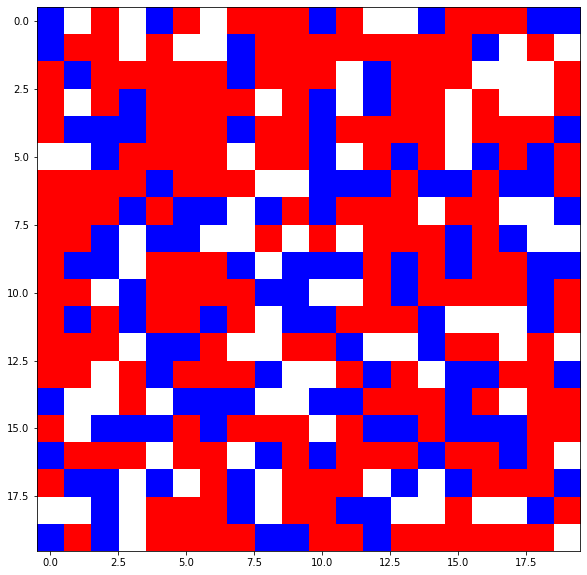

In [16]:
print_matrix(matrix)

<ipython-input-6-e19d9eb95edd>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


PAREI NO 53


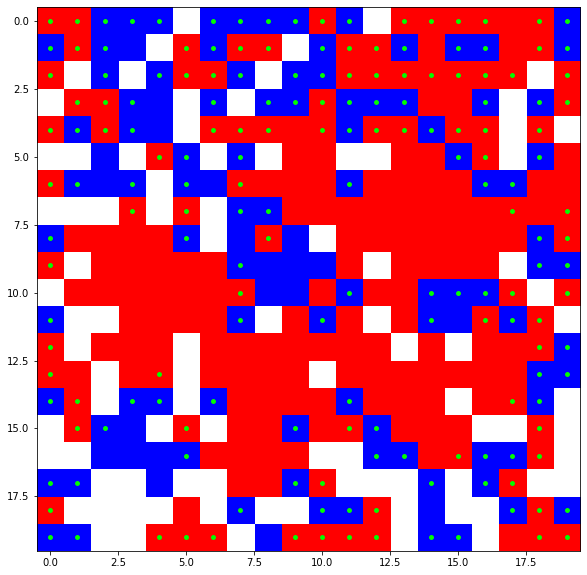

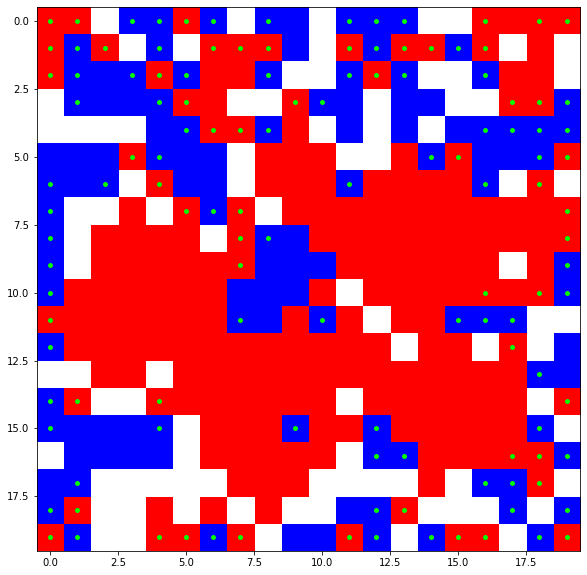

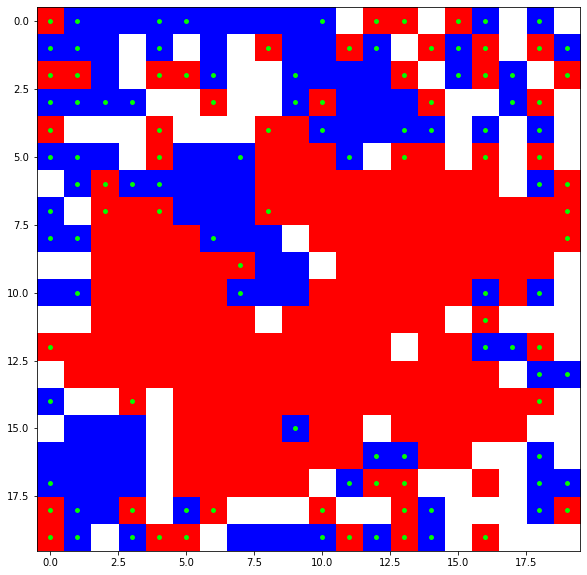

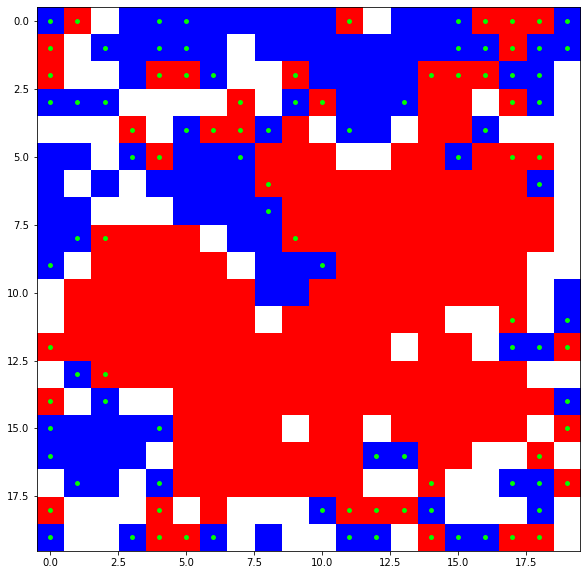

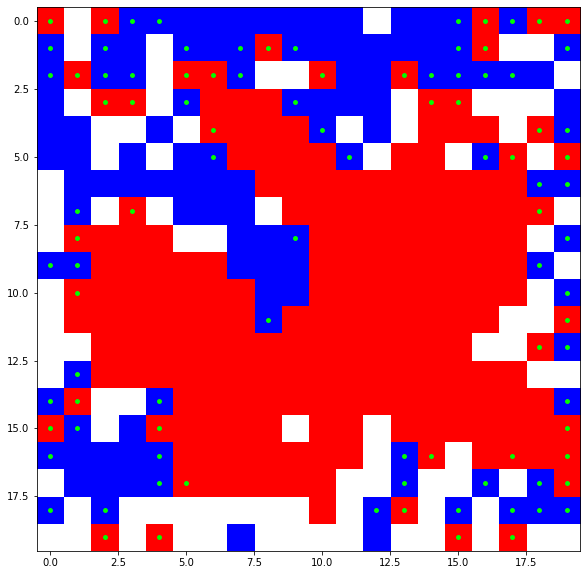

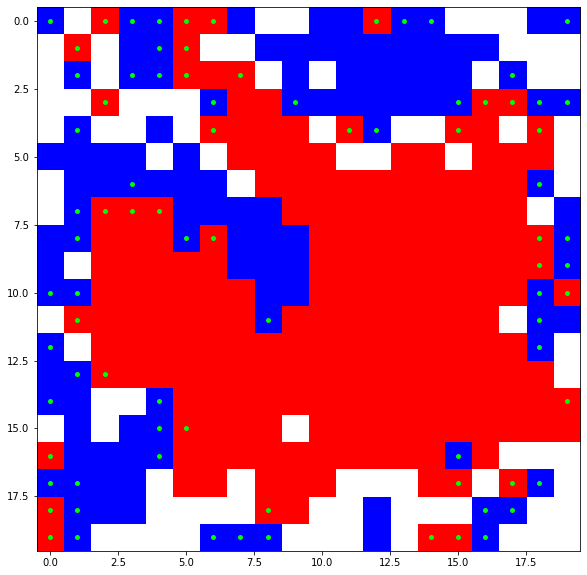

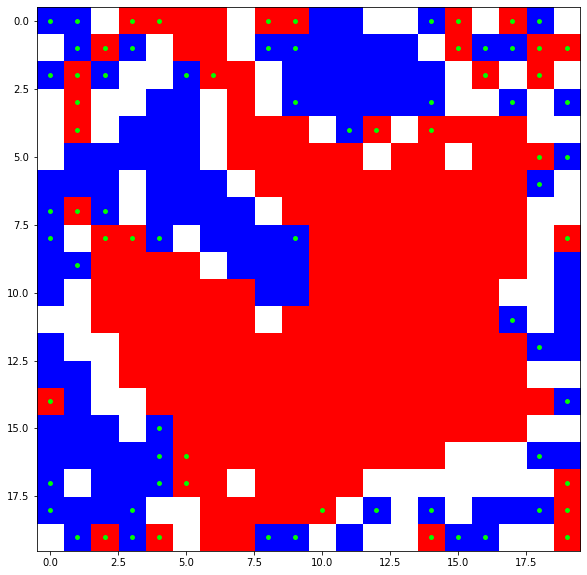

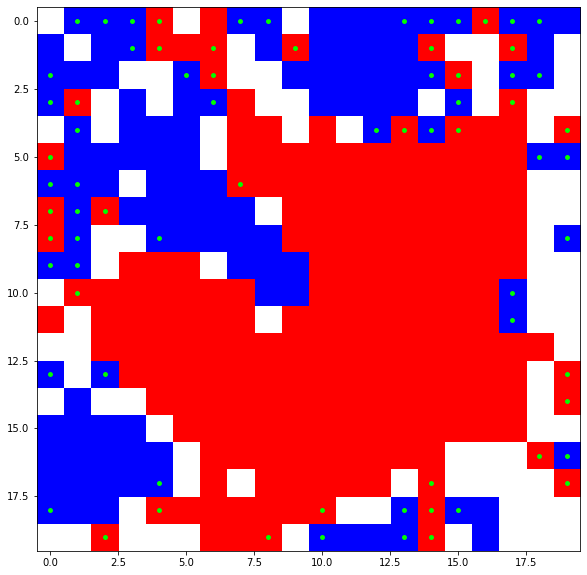

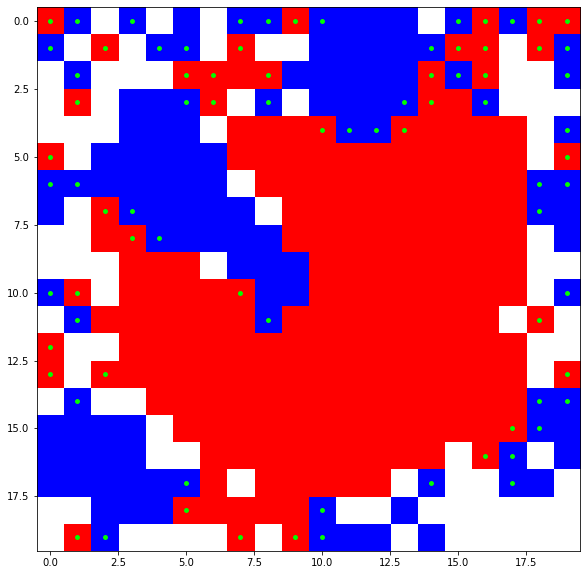

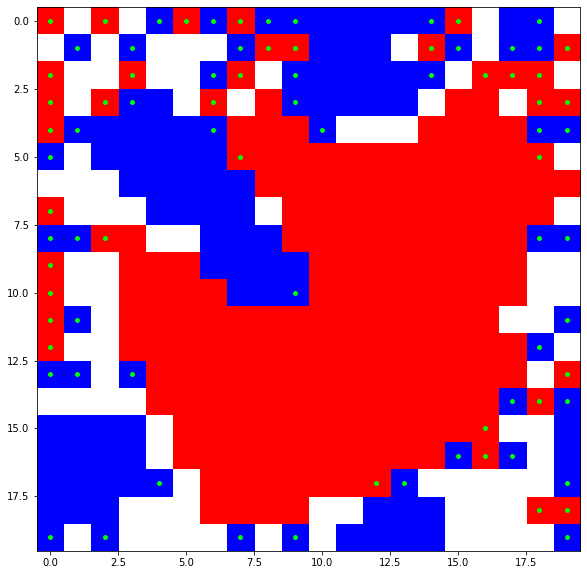

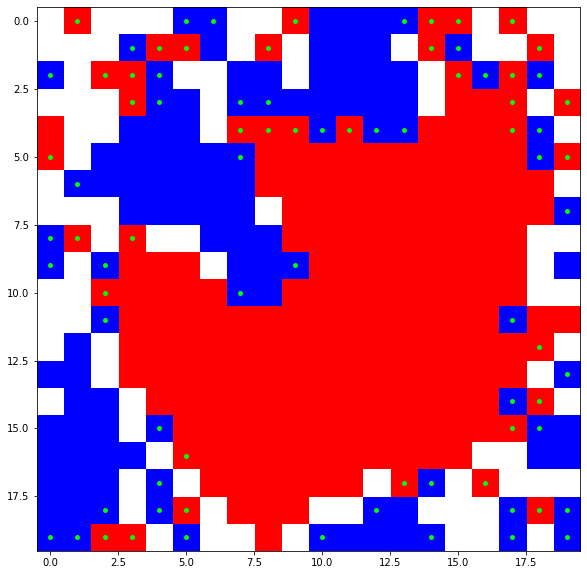

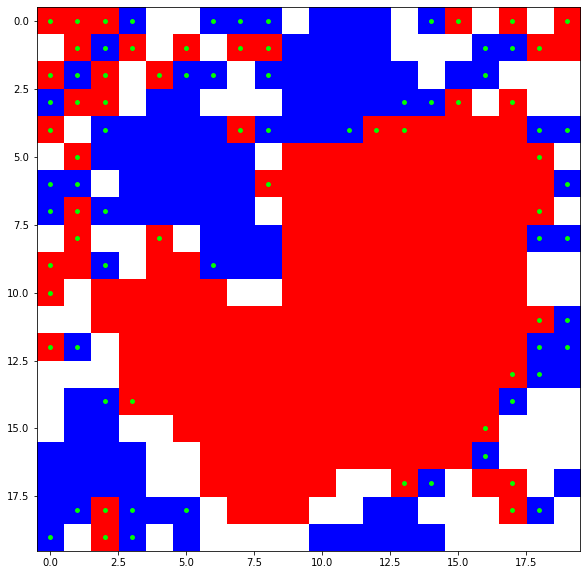

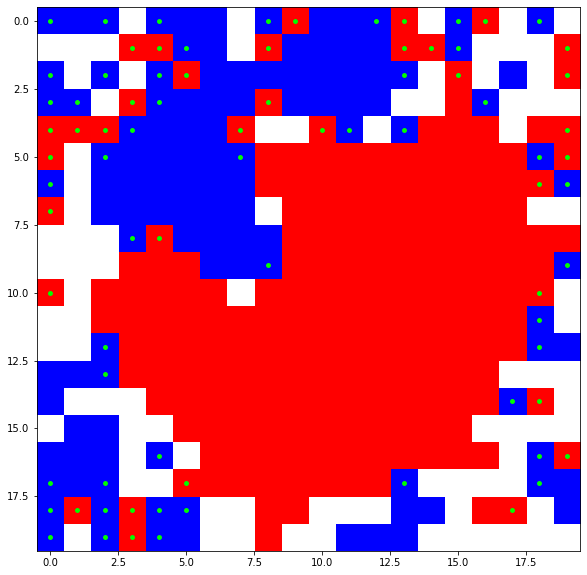

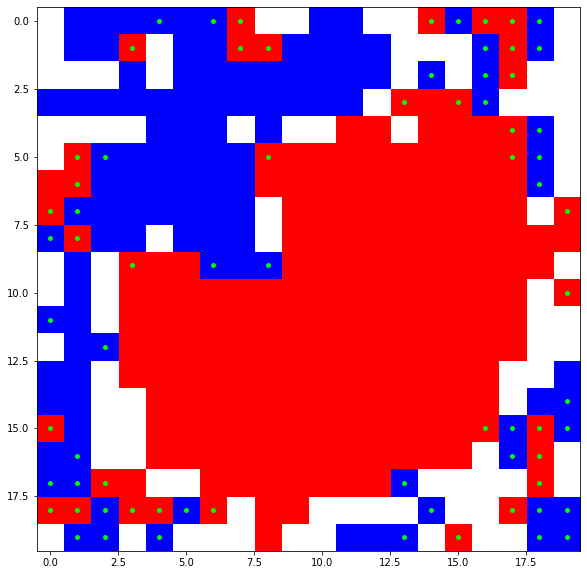

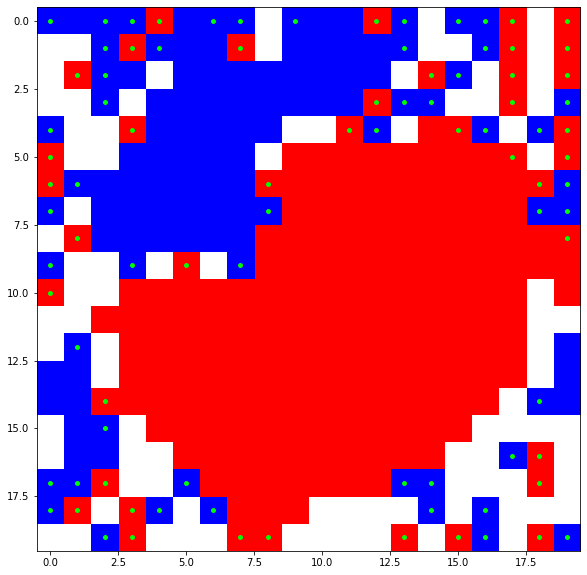

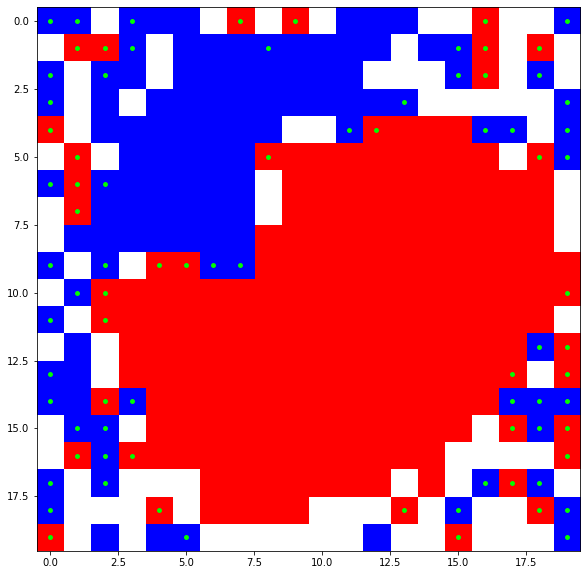

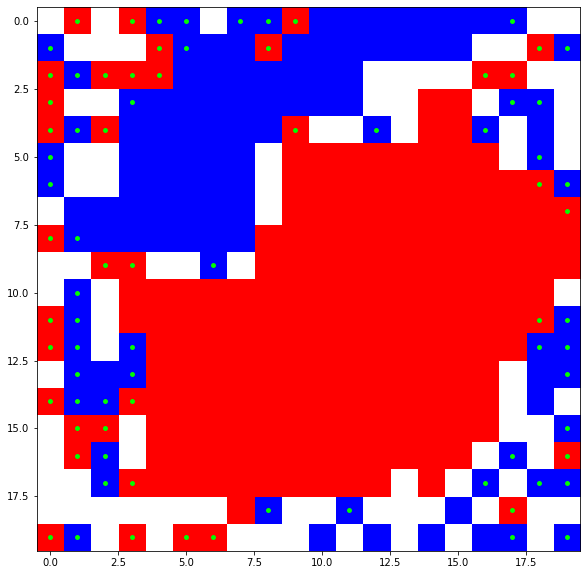

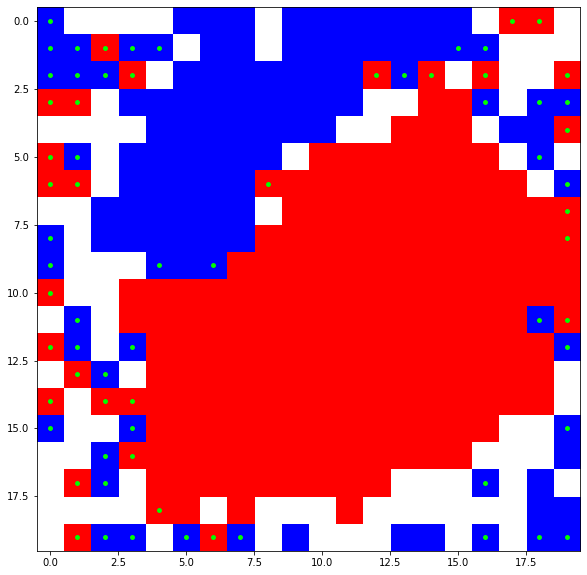

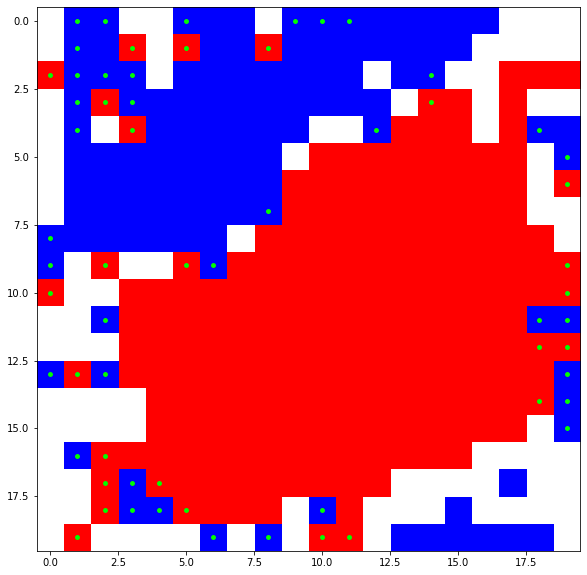

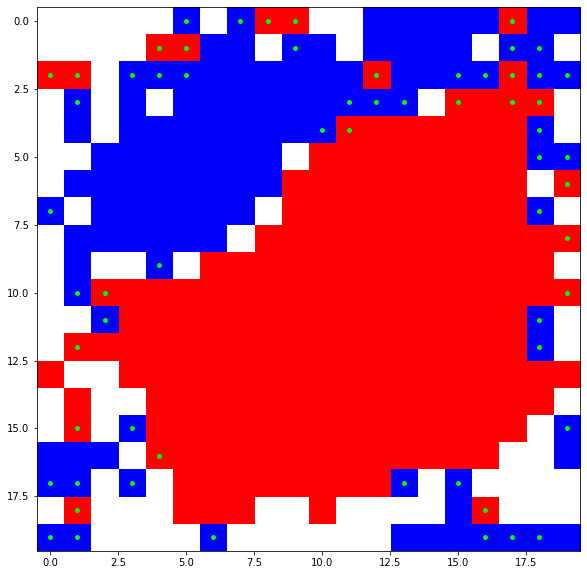

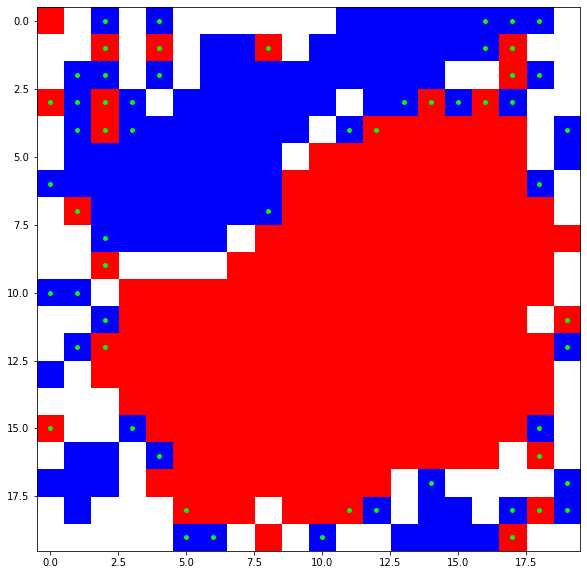

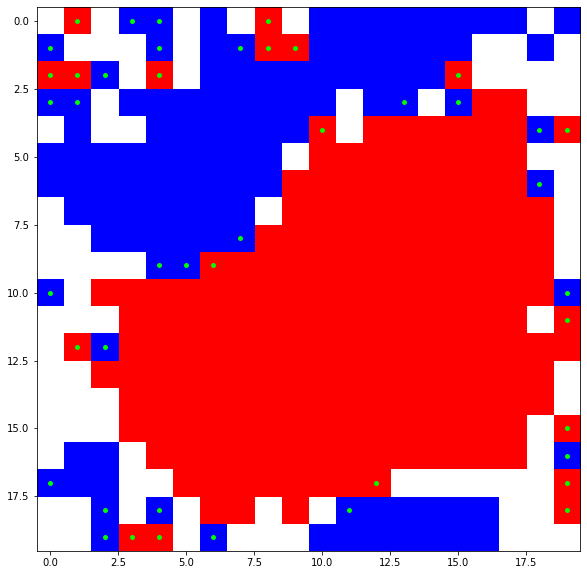

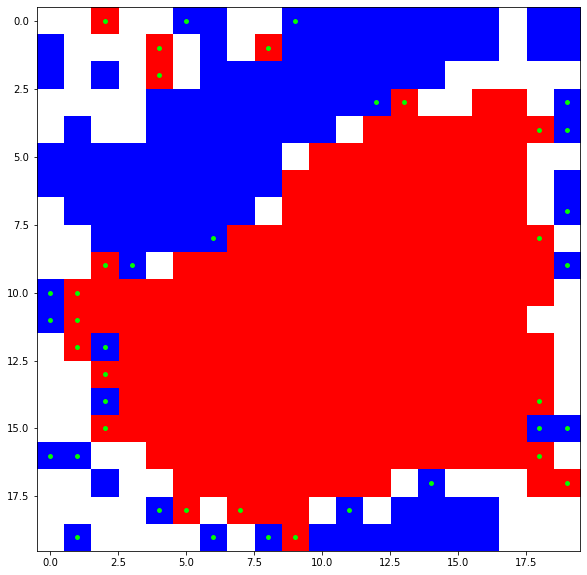

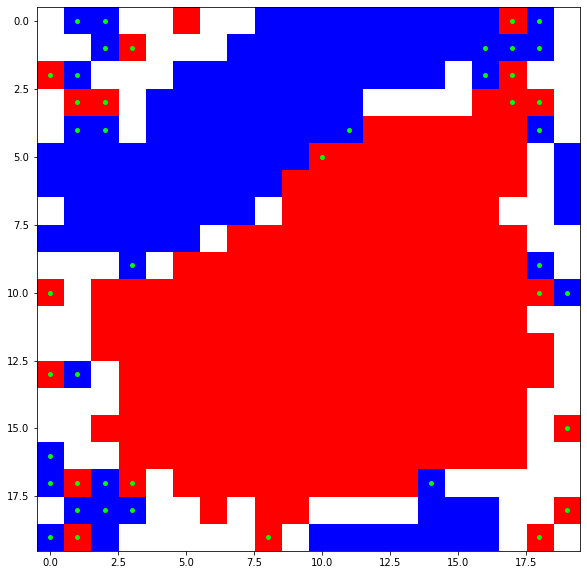

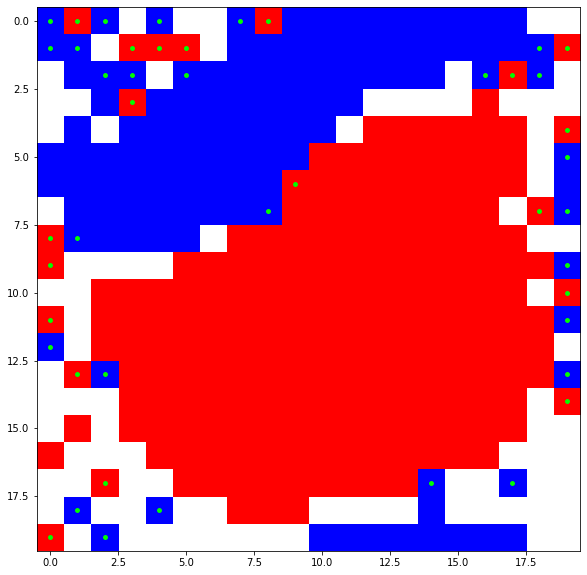

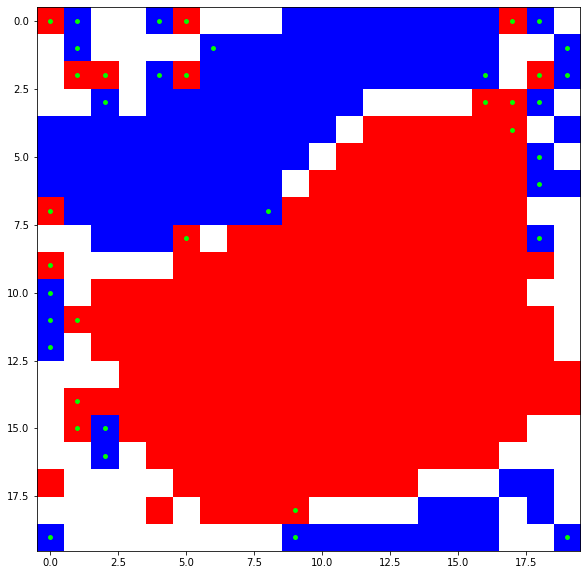

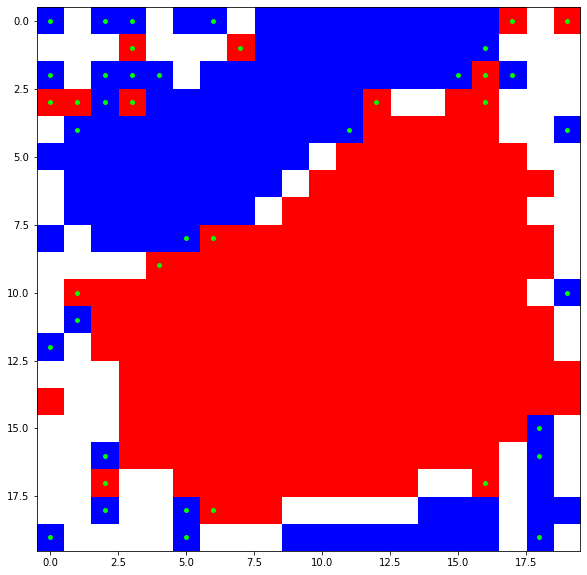

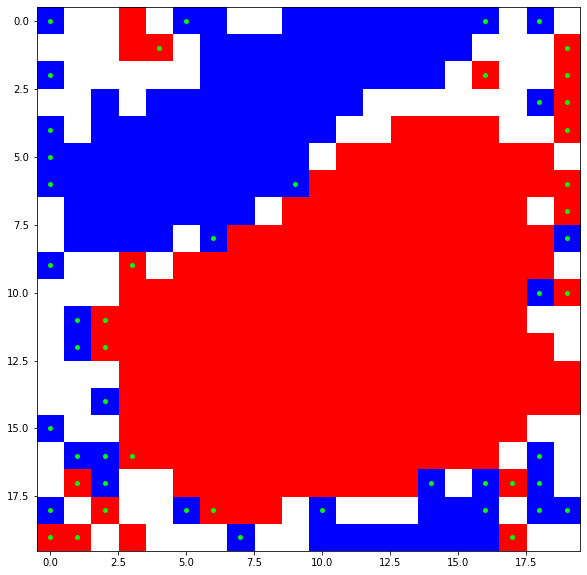

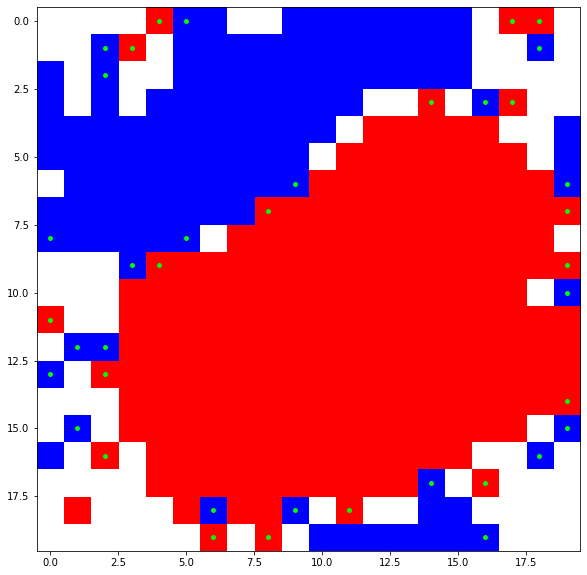

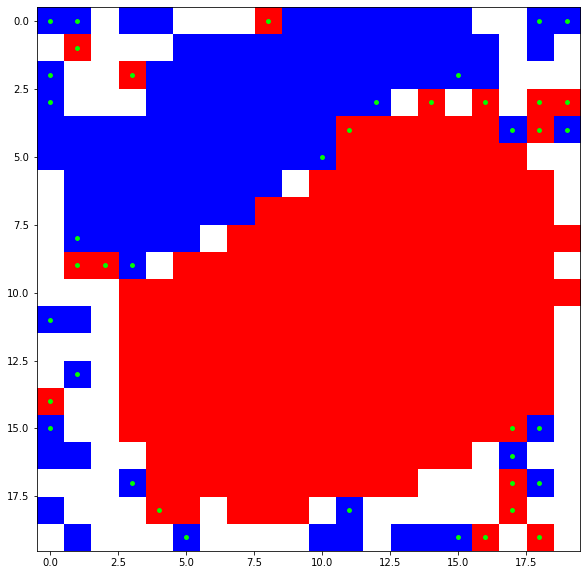

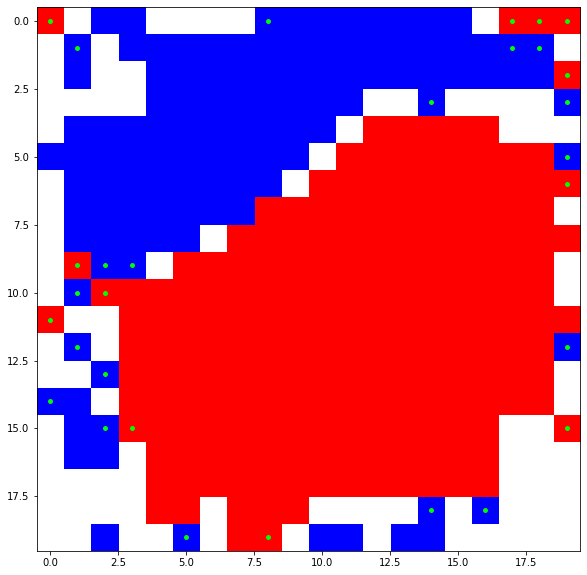

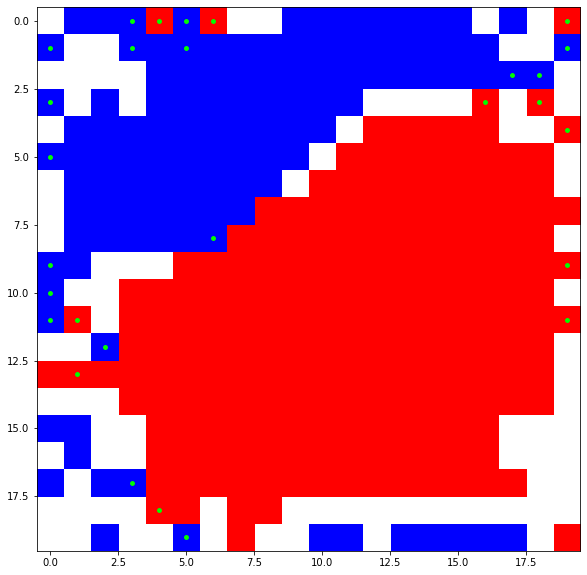

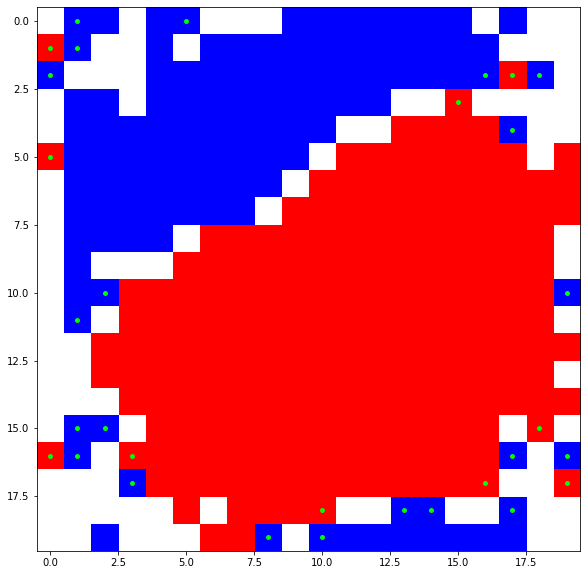

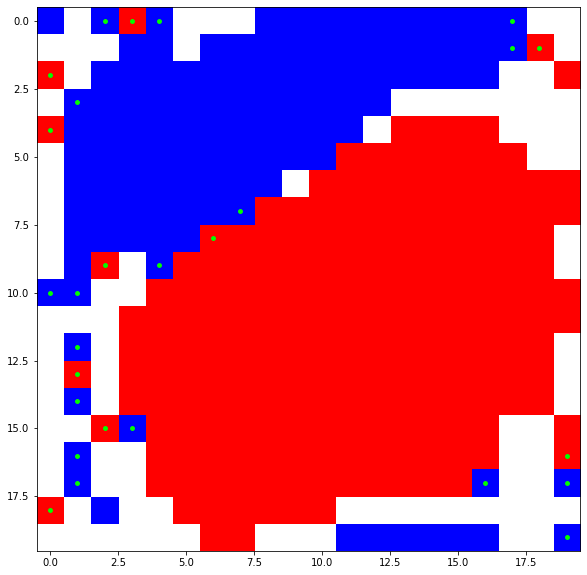

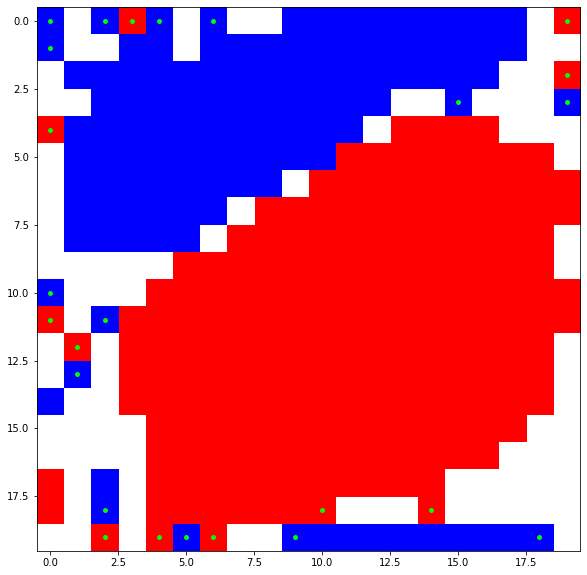

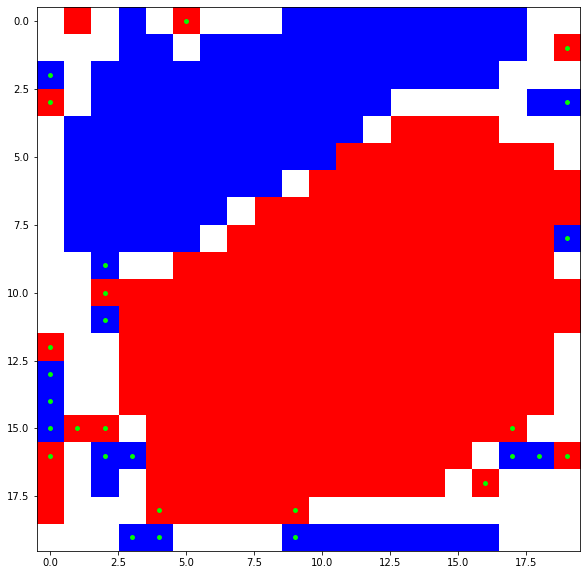

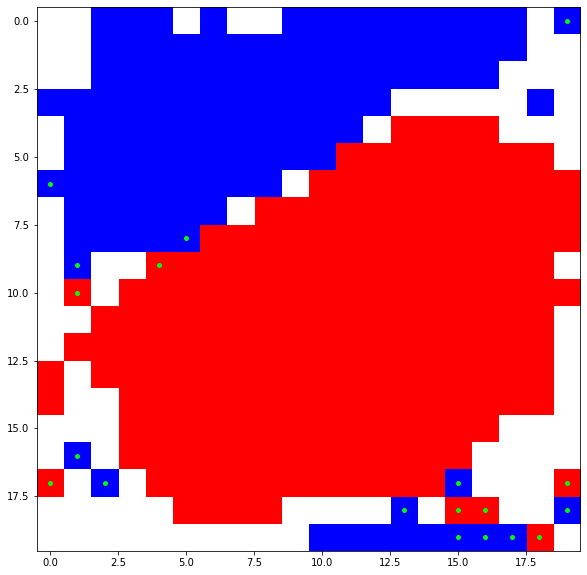

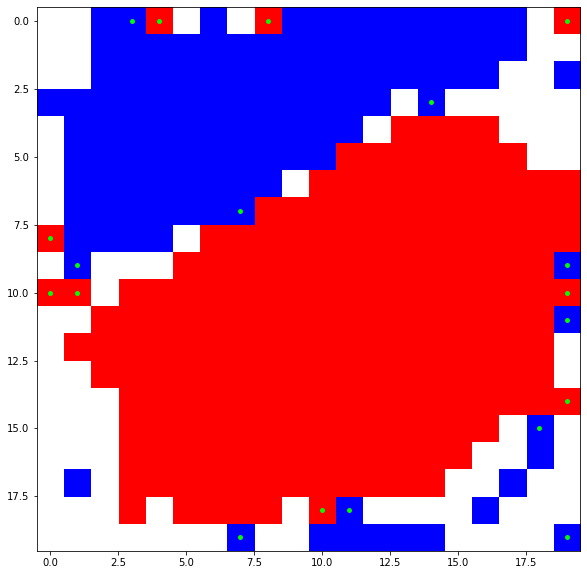

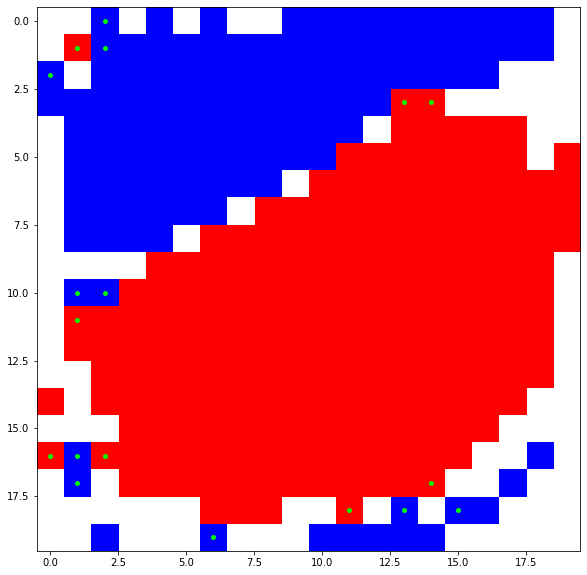

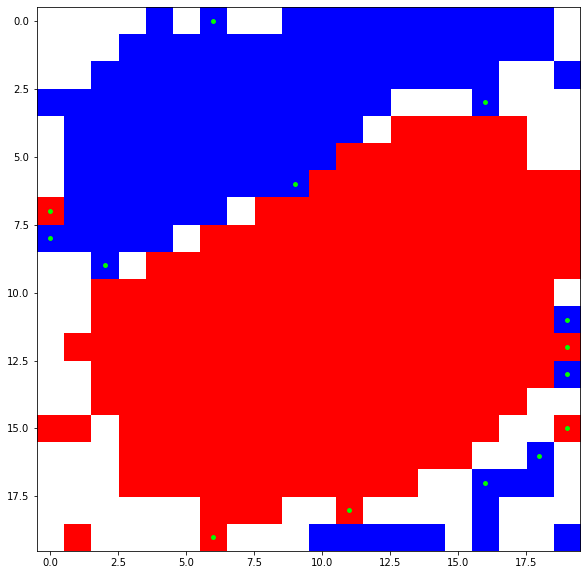

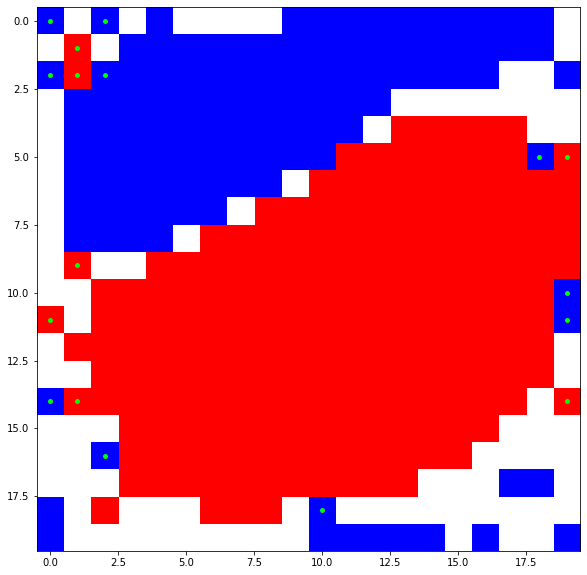

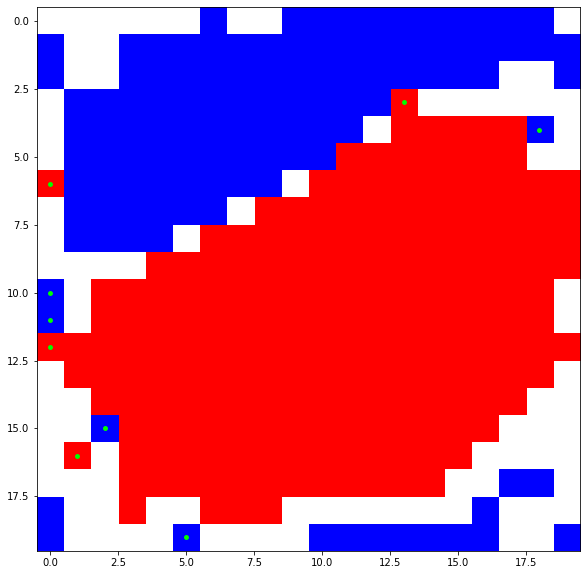

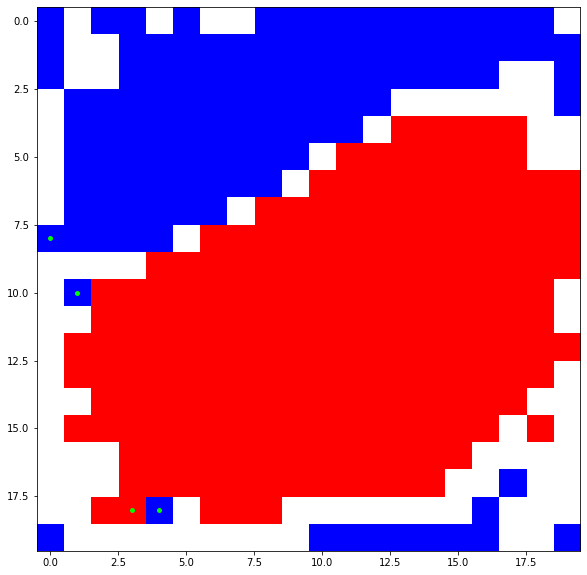

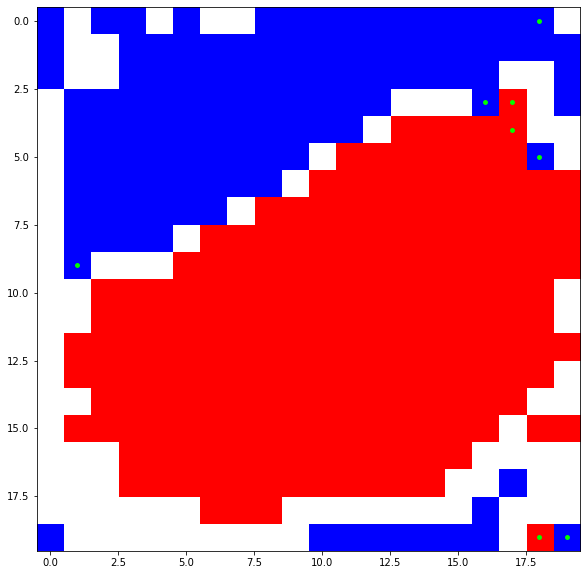

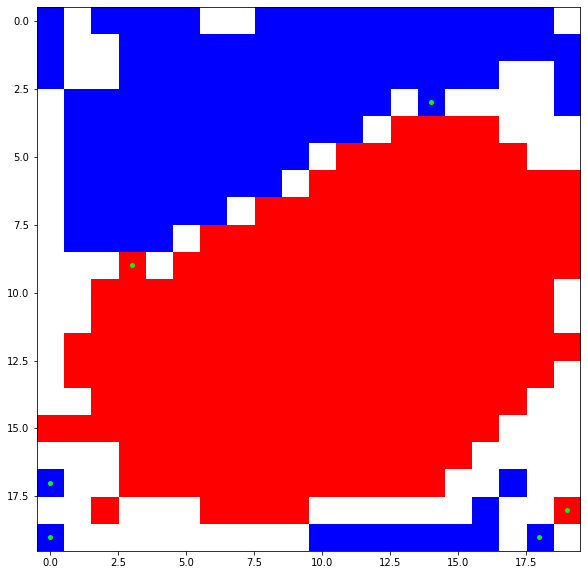

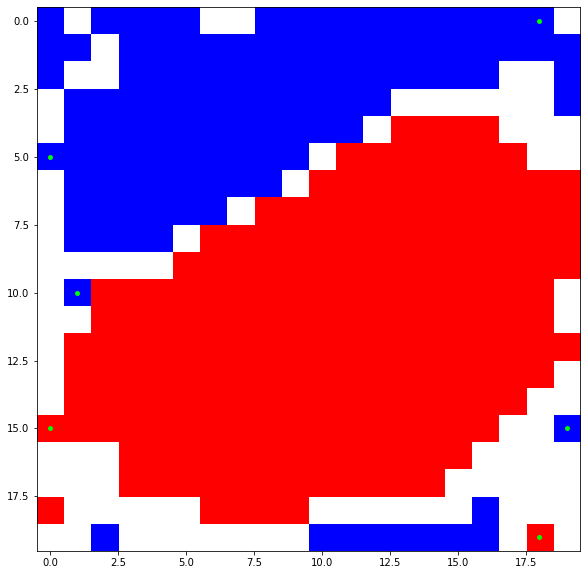

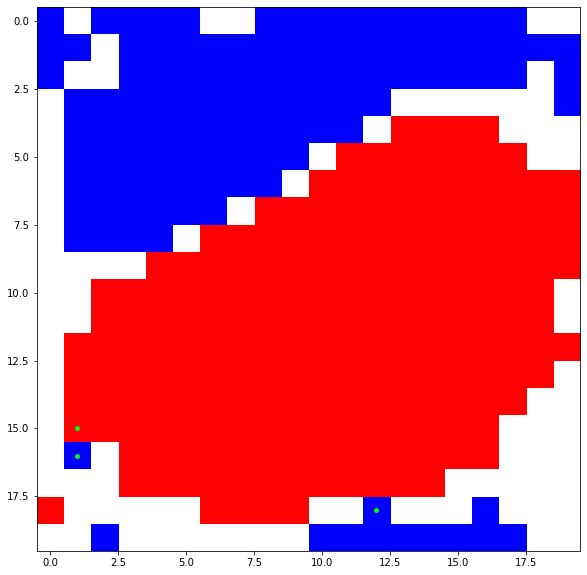

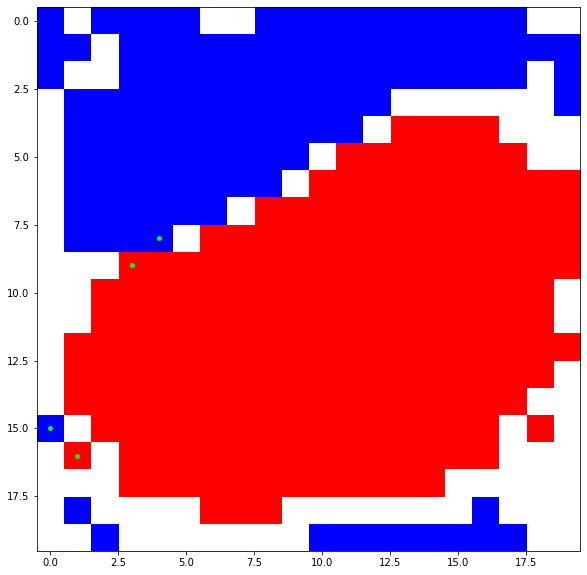

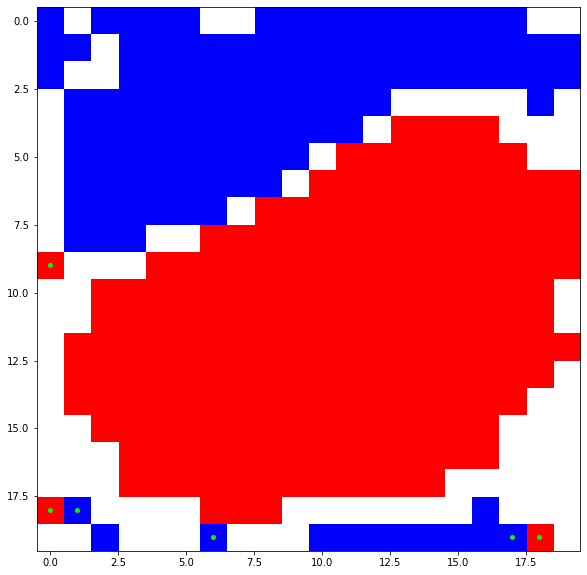

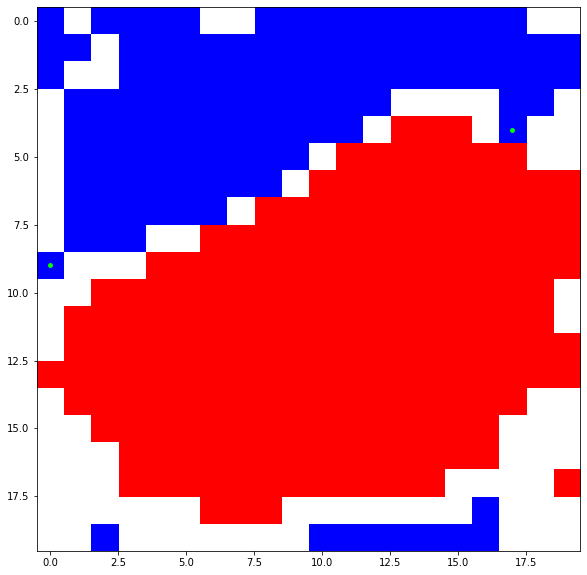

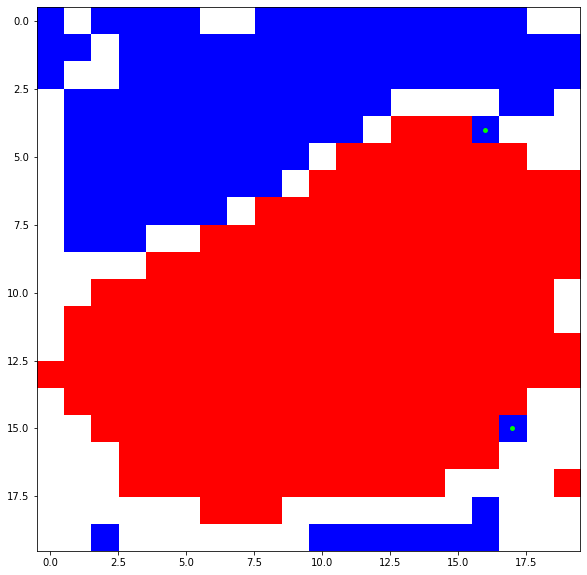

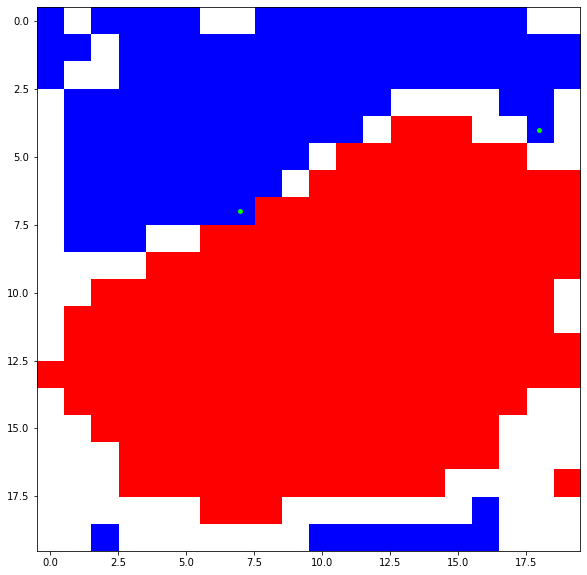

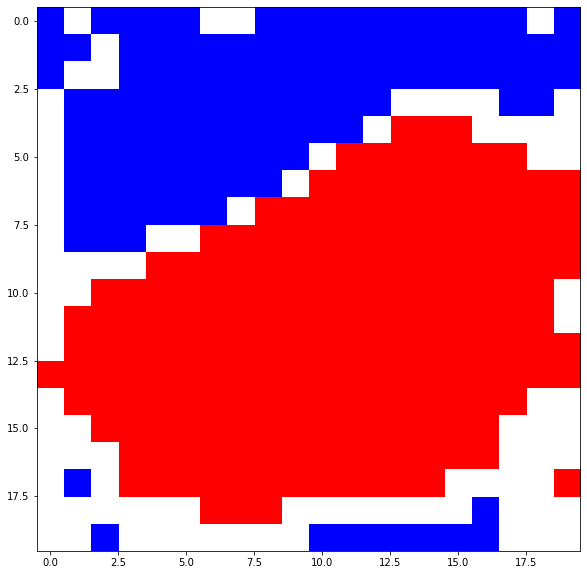

In [17]:
matrix = make_matrix(20)

for i in range(100):
    new_matrix = iteration(matrix)
    
    if new_matrix == "STOP":
        print("PAREI NO " + str(i))
        break
        
    matrix = new_matrix.copy()
    
    print_matrix(matrix, save=True, filename='imag/iter_' + str(i) + '.png', marker=get_dissatisfied(iteration(matrix), dis_algo))

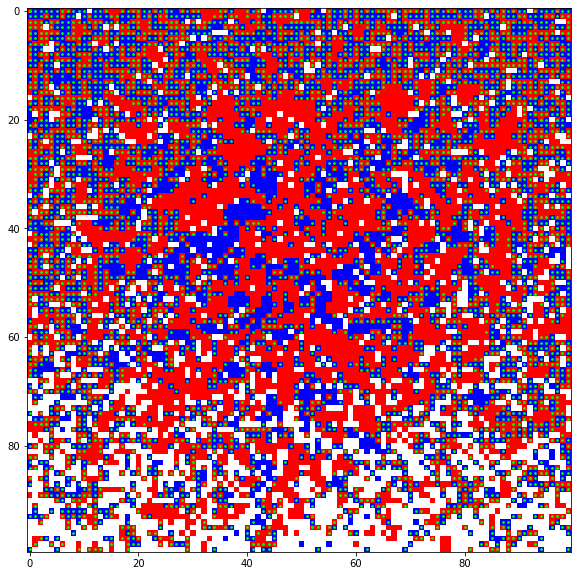

In [18]:
matrix = make_matrix(100)

print_matrix(matrix, get_dissatisfied(iteration(matrix), dis_algo))